测试pipeline输出的图像和标注的正确

In [16]:
# Copyright (c) OpenMMLab. All rights reserved.
import argparse
import logging
import os
import os.path as osp

from mmengine.config import Config, DictAction
from mmengine.logging import print_log
from mmengine.runner import Runner

from mmyolo.registry import RUNNERS
from mmyolo.utils import is_metainfo_lower

import torch
import mmcv
from mmdet.apis import inference_detector, init_detector
from mmengine import Config, DictAction
from mmengine.registry import init_default_scope
from mmengine.utils import ProgressBar

from mmyolo.registry import VISUALIZERS
from mmyolo.utils.misc import auto_arrange_images, get_file_list
torch.cuda.set_device(3)

In [17]:
class ActivationsWrapper:

    def __init__(self, model, target_layers):
        self.model = model
        self.activations = []
        self.handles = []
        self.image = None
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))

    def save_activation(self, module, input, output):
        self.activations.append(output)

    def __call__(self, img_path):
        self.activations = []
        results = inference_detector(self.model, img_path)
        return results, self.activations

    def release(self):
        for handle in self.handles:
            handle.remove()

In [18]:
cfg_path = '/root/mmyolo/work_dirs/yolo_20230831/20230831_144152/vis_data/config.py'
cfg = Config.fromfile(cfg_path)
cfg.launcher = 'none'
cfg.work_dir = '/root/mmyolo/work_dirs/yolo_20230703_1/'
ckpt = '/root/mmyolo/work_dirs/yolo_20230831/20230831_144152/best_coco_bbox_mAP_50_epoch_25.pth'
runner = Runner.from_cfg(cfg)

08/31 15:12:10 - mmengine - WARNING - Failed to search registry with scope "mmyolo" in the "log_processor" registry tree. As a workaround, the current "log_processor" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmyolo" is a correct scope, or whether the registry is initialized.


08/31 15:12:14 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
08/31 15:12:14 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(49          ) EMAHook                            
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
after_load_checkpoint:
(49          ) EMAHook                            
 -------------------- 
before_train:
(9           ) YOLOv5ParamSchedulerHook           
(VERY_HIGH   ) RuntimeInfoHook                    
(49          ) EMAHook                            
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHo

比较加transformer前后的特征图是否有区别

In [19]:
model = init_detector(cfg, ckpt, device='cuda:0')

Loads checkpoint by local backend from path: /root/mmyolo/work_dirs/yolo_20230831/20230831_144152/best_coco_bbox_mAP_50_epoch_25.pth


In [20]:
target_layers = []
# for target_layer in ['bbox_head.head_module.reg_preds[0]']:
for target_layer in ['backbone']:
    try:
        target_layers.append(eval(f'model.{target_layer}'))
    except Exception as e:
        print(model)
        raise RuntimeError('layer does not exist', e)

activations_wrapper = ActivationsWrapper(model, target_layers)

# init visualizer
visualizer = VISUALIZERS.build(model.cfg.visualizer)
visualizer.dataset_meta = model.dataset_meta

# get file list
img = '/root/mmyolo/data/coco3/val2017/3.jpg'
result, featmaps = activations_wrapper(img)

08/31 15:12:17 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io


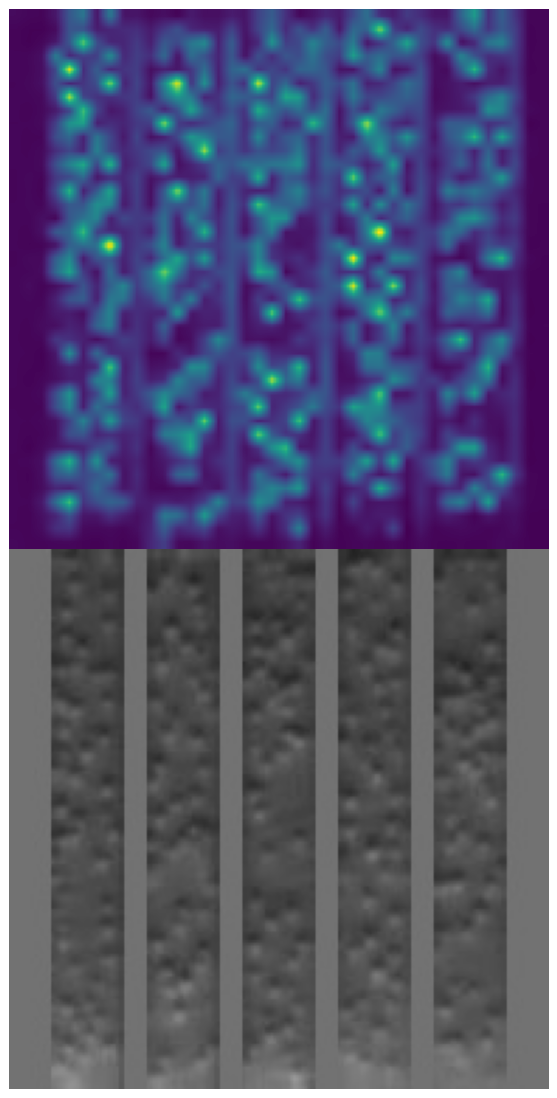

In [21]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

img = mmcv.imread(img)
img = mmcv.imconvert(img, 'bgr', 'rgb')
feat = featmaps[0][0][0].detach().cpu()
feat = F.interpolate(feat[None], (192, 192), mode='bilinear', align_corners=False)[0]
feat = torch.mean(feat, dim=0)

fig = plt.figure(1, dpi=90, figsize=(12, 12))
fig.subplots_adjust(
                left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.axis('off')
ax2.axis('off')
ax1.imshow(feat)
ax2.imshow(img)

In [ ]:
from mmengine.model import is_model_wrapper

if is_model_wrapper(runner.model):
    ori_model = runner.model.module
else:
    ori_model = runner.model
assert hasattr(ori_model, 'train_step'), (
    'If you want to train your model, please make sure your model '
    'has implemented `train_step`.')

if runner._val_loop is not None:
    assert hasattr(ori_model, 'val_step'), (
        'If you want to validate your model, please make sure your '
        'model has implemented `val_step`.')

if runner._train_loop is None:
    raise RuntimeError(
        '`runner._train_loop` should not be None when calling train '
        'method. Please provide `train_dataloader`, `train_cfg`, '
        '`optimizer` and `param_scheduler` arguments when '
        'initializing runner.')

runner._train_loop = runner.build_train_loop(
    runner._train_loop)  # type: ignore

# `build_optimizer` should be called before `build_param_scheduler`
#  because the latter depends on the former
runner.optim_wrapper = runner.build_optim_wrapper(runner.optim_wrapper)
# Automatically scaling lr by linear scaling rule
runner.scale_lr(runner.optim_wrapper, runner.auto_scale_lr)

if runner.param_schedulers is not None:
    runner.param_schedulers = runner.build_param_scheduler(  # type: ignore
        runner.param_schedulers)  # type: ignore

if runner._val_loop is not None:
    runner._val_loop = runner.build_val_loop(
        runner._val_loop)  # type: ignore
# TODO: add a contextmanager to avoid calling `before_run` many times
runner.call_hook('before_run')

# initialize the model weights
runner._init_model_weights()
# make sure checkpoint-related hooks are triggered after `before_run`
runner.load_or_resume()

# Initiate inner count of `optim_wrapper`.
runner.optim_wrapper.initialize_count_status(
    runner.model,
    runner._train_loop.iter,  # type: ignore
    runner._train_loop.max_iters)  # type: ignore

# Maybe compile the model according to options in runner.cfg.compile
# This must be called **AFTER** model has been wrapped.
runner._maybe_compile('train_step')

runner.call_hook('before_train')
runner.call_hook('before_train')
runner.call_hook('before_train_epoch')


loading annotations into memory...
Done (t=2.56s)
creating index...
index created!
08/30 09:44:40 - mmengine - INFO - Optimizer groups: 41 .bias, 41 conv.weight, 37 other
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
08/30 09:44:43 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
08/30 09:44:43 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
08/30 09:44:43 - mmengine - INFO - Checkpoints will be saved to /root/mmyolo/work_dirs/yolo_20230703_1.
08/30 09:44:43 - mmengine - INFO - Checkpoints will be saved to /root/mmyolo/work_dirs/yolo_20230703_1.
08/30 09:44:43 - mmengine - INFO - Switch pipeline now!


In [8]:
for i, m in enumerate(runner.model.modules()):
    print(f'{i} {m}')

0 YOLODetector(
  (data_preprocessor): YOLOv5DetDataPreprocessor()
  (backbone): YOLOv8CSPDarknet(
    (stem): ConvModule(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (activate): SiLU(inplace=True)
    )
    (stage1): Sequential(
      (0): ConvModule(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (activate): SiLU(inplace=True)
      )
      (1): CSPLayerWithTwoConv(
        (main_conv): ConvModule(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (activate): SiLU(inplace=True)
        )
        (final_conv): ConvModule(
          (conv): Conv2d(48, 32, kerne

In [ ]:
runner.model.train()

In [26]:
train_dataloader = runner.train_dataloader